# Monte Carlo sampling for sum rule analysis

In [74]:
# imports:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import json

In [75]:
from xaspy.xas.polarized import Lz,Sz

In [76]:
# visual processing if installed ( '$ pip install tqdm' )
try: 
    from tqdm import tqdm 
except:
    def tqdm(a):
        return a

In [208]:
# define functions: 
from xaspy.xas.backgrounds import step

# define two step function: 
def _step(x,xas,step1,step2,slope=None, br=2/3):
    final_step_hight = np.array(xas)[-1]
    stepx = step(final_step_hight*br,
                 step1,x,slope=slope) + step(final_step_hight*(1-br),
                                             step2,x,slope=slope)
    xas00 = xas - stepx
    return xas00, stepx

# define different distributions: 
def define_dist(a,b,dist='normal'):
    if b == None or dist == None:
        return a
    if dist == 'normal':
        return np.random.normal(a,b)
    elif dist == 'randint':
        return np.random.randint(a,b)
    elif dist == 'uniform':
        return np.random.uniform(a,b)
    else:
        raise SyntaxError('distribution not in list, choose normal, uniform or randint distribution')

# import the data

In [209]:
with open('2021-06-DG-ALS_XMCD_analysis.json') as f:
    jsn = json.load(f)
############ 


name = 'GG0007'
element = 'Sm'
angle = '0deg'
sample = jsn[name]
print('importable keys:')
print(sample[element][angle].keys())

importable keys:
dict_keys(['energy', 'LYxmcd', 'LYxas', 'LYxasp', 'LYxasm', 'EYxmcd', 'EYxas', 'EYxasp', 'EYxasm'])


In [240]:
### you can import data of course in other ways
# x -> energy axis
# y -> xas axis
# z -> xmcd axis

x = np.array(sample[element][angle]['energy'])
y = np.array(sample[element][angle]['LYxas'])
z = np.array(sample[element][angle]['LYxmcd'])/0.9 # estimation of 90% circular polarization

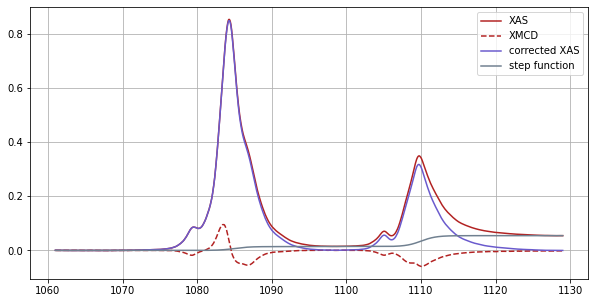

In [241]:
# implementing parameters
# parameters should be chosen to substract the background well

initial_step1 = 1085
initial_step2 = 1110
initial_slope = 1.0 # TODO in eV fwhm , also slope not really important? 
initial_branching = 1.3/5 #y[int(len(x)/2)]

###########

# plot
plt.figure(figsize=(10,5))
plt.plot(x, y, color='firebrick')
plt.plot(x, z, color='firebrick', linestyle='dashed')

plt.plot(x,_step(x, y,initial_step1, initial_step2, 
                 slope=initial_slope, br=initial_branching)[0],
         color='slateblue',alpha=1)
plt.plot(x,_step(x, y,initial_step1, initial_step2, 
                 slope=initial_slope, br=initial_branching)[1], 
         color='slategrey',alpha=1)
plt.grid()
plt.legend(['XAS', 'XMCD', 'corrected XAS','step function'])
plt.show()


In [242]:
# choose parameters to vary the range for the step function
# 
monte_parameters = dict({
     'step1_dist': (initial_step1, 1.,'normal'), #np.random.normal(initial_step1, 1, 5),
     'step2_dist': (initial_step2, 1.,'normal'),#np.random.normal(initial_step2, 0.25, 5),
     'slope_dist': (initial_slope, None,'normal'), #np.random.normal(initial_slope, .1, 5),
     'branching_dist': (initial_branching, None),#[initial_branching],#np.random.normal(initial_branching, .01, 10),
                        })

In [243]:
monte_parameters

{'step1_dist': (1085, 1.0, 'normal'),
 'step2_dist': (1110, 1.0, 'normal'),
 'slope_dist': (1.0, None, 'normal'),
 'branching_dist': (0.26, None)}

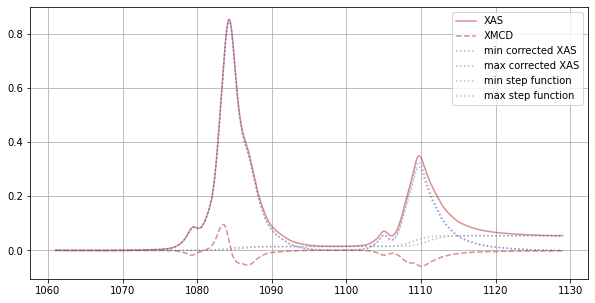

In [244]:
# plot extremes:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='firebrick', alpha=.5)
plt.plot(x, z, color='firebrick', linestyle='dashed', alpha=.5)

plt.plot(x,_step(x, y, monte_parameters['step1_dist'][0]-monte_parameters['step1_dist'][1], 
                       monte_parameters['step2_dist'][0]-monte_parameters['step2_dist'][1], 
                 slope=initial_slope, br=initial_branching)[0],
         color='slateblue',alpha=0.5,linestyle='dotted')

plt.plot(x,_step(x, y, monte_parameters['step1_dist'][0]+monte_parameters['step1_dist'][1], 
                       monte_parameters['step2_dist'][0]+monte_parameters['step2_dist'][1], 
                 slope=initial_slope, br=initial_branching)[0],
         color='slateblue',alpha=0.5,linestyle='dotted')


plt.plot(x,_step(x, y, monte_parameters['step1_dist'][0]-monte_parameters['step1_dist'][1], 
                       monte_parameters['step2_dist'][0]-monte_parameters['step2_dist'][1], 
                 slope=initial_slope, br=initial_branching)[1],
         color='slategrey',alpha=.5,linestyle='dotted')

plt.plot(x,_step(x, y, monte_parameters['step1_dist'][0]+monte_parameters['step1_dist'][1], 
                       monte_parameters['step2_dist'][0]+monte_parameters['step2_dist'][1], 
                 slope=initial_slope, br=initial_branching)[1],
         color='slategrey',alpha=.5,linestyle='dotted')


plt.grid()
plt.legend(['XAS', 'XMCD', 'min corrected XAS', 'max corrected XAS','min step function','max step function'])
plt.show()


In [245]:
# add further parameters for sum rule analysis:
monte_parameters['nh_dist'] =  (9,None,'normal') # np.random.normal(3, 0.1, 100) or eg. [3]
monte_parameters['tz_dist'] =  (-.4,0.1,'uniform') # np.random.normal(0, 0.01, 10) or eg. [0]
monte_parameters['last_number_xas_dist'] = (1,300,'randint') #np.random.randint(1, 1000 , 10)
monte_parameters['last_number_xmcd_dist'] =  (1,300,'randint') #np.random.randint(1, 100 , 10)
monte_parameters['edge_divider_dist'] = (-30,300,'randint') # np.random.randint(-230, 100 , 10)

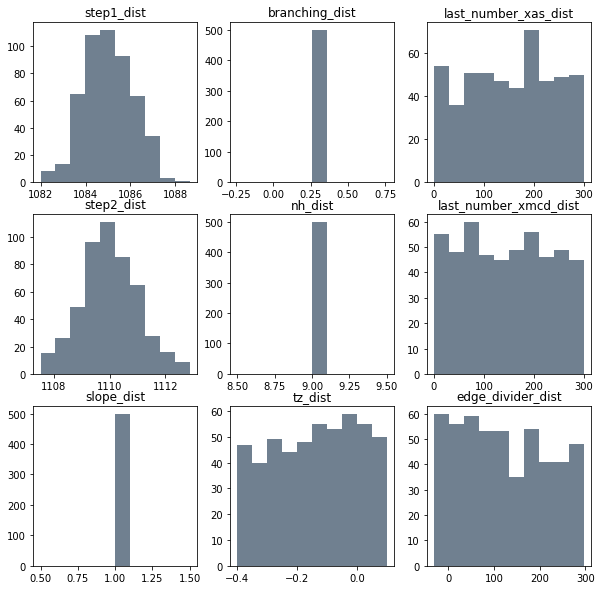

In [246]:

for_grid = int(np.ceil(np.sqrt(len(monte_parameters))))

fig, axs = plt.subplots(for_grid, for_grid, figsize = (10,10))
c,i = 0,0
for n in list(monte_parameters):
    try:
        axs[c,i].set_title(n)
        _list = list()
        for f in range(500):
            _list.append(define_dist(*monte_parameters[n]))
        axs[c,i].hist(_list,color='Slategrey')
        c += 1 
        if c == for_grid:
            i += 1
            c = 0
    except:
        pass
plt.show()

if the parameters set lets dive into the sum rules:

import functions for Lz and Sz, double check if the right transitions were chosen

In [247]:
sampling_size = 10000


whole_set = list()
for i in range(sampling_size):
    param_set = [
        define_dist(*monte_parameters['step1_dist']), # step1
        define_dist(*monte_parameters['step2_dist']), # step2
        define_dist(*monte_parameters['slope_dist']), # slope
        define_dist(*monte_parameters['branching_dist']), # branching
        define_dist(*monte_parameters['nh_dist']), # nh
        define_dist(*monte_parameters['tz_dist']), # Tz
        define_dist(*monte_parameters['last_number_xas_dist']), # last_number_xas_dist
        define_dist(*monte_parameters['last_number_xmcd_dist']), # last_number_xmcd_dist
        define_dist(*monte_parameters['edge_divider_dist']), # last_number_xmcd_dist
    ]
    whole_set.append(param_set)

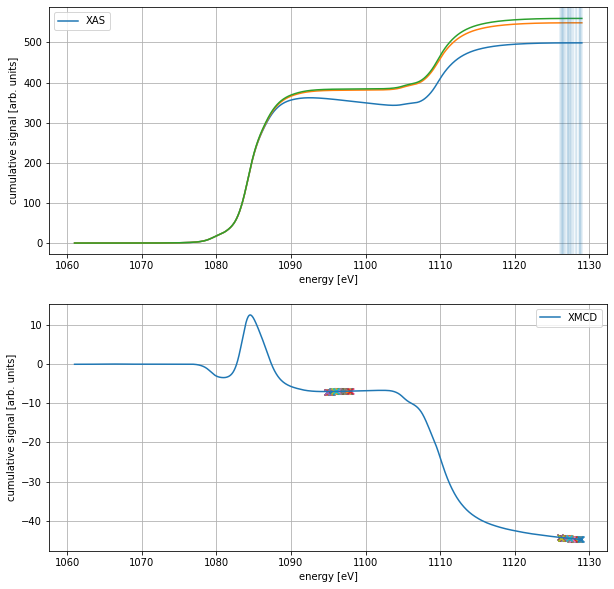

In [248]:
initial_corrected_xas_cs = np.cumsum(_step(x, y,initial_step1, 
                                           initial_step2, 
                                           slope=initial_slope)[0])
initial_corrected_xas_cs_1 = np.cumsum(_step(x, y, monte_parameters['step1_dist'][0]-monte_parameters['step1_dist'][1], 
                       monte_parameters['step2_dist'][0]-monte_parameters['step2_dist'][1], 
                 slope=initial_slope, br=initial_branching)[0])
initial_corrected_xas_cs_2 = np.cumsum(_step(x, y, monte_parameters['step1_dist'][0]+monte_parameters['step1_dist'][1], 
                       monte_parameters['step2_dist'][0]+monte_parameters['step2_dist'][1], 
                 slope=initial_slope, br=initial_branching)[0])

number_of_points = 50

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(x,initial_corrected_xas_cs)
plt.plot(x,initial_corrected_xas_cs_1)
plt.plot(x,initial_corrected_xas_cs_2)

for n in list(np.array(whole_set)[:,6])[:number_of_points]:
    n = int(n)
    plt.axvline(x[len(z)-n],linewidth=.1)
plt.grid()

plt.xlabel('energy [eV]')
plt.ylabel('cumulative signal [arb. units]')
plt.legend(['XAS'])

plt.subplot(212)

plt.plot(x,np.cumsum(z))
for n in list(np.array(whole_set)[:,7])[:number_of_points]:
    n = int(n)
    plt.scatter(x[len(z)-n], np.cumsum(z)[-n],marker='x')

for n in list(np.array(whole_set)[:,8])[:number_of_points]:
    n = int(n)
    plt.scatter(x[int(len(z)/2)+n], np.cumsum(z)[int(len(z)/2)+n],marker='x')

plt.legend(['XMCD'])
plt.xlabel('energy [eV]')
plt.ylabel('cumulative signal [arb. units]')
plt.grid()
plt.show()    


# OK! lets calculate! 

this step can take a few minutes to hours to weeks to years, depending on how large your sample size is!



In [249]:
# g-factor:
g = 2
#important: change c and l when changing the edge
c = 2
l = c+1



###################
lz_list = list()
sz_list = list()
mu_tot_list = list()
# ratio of orbital to spin moment, 
# indepent of XAS and nh if Tz = 0
mu_rat_list = list()

for n in tqdm(whole_set):
    #calculate:
    xas_corr = np.array(_step(x, y, n[0], n[1], 
                                         slope=float(n[2]),
                                         br=n[3] )[1])
    lz = Lz(z,xas_corr,
            c=c,l=l,
            nh=n[4],
            last_number_xas=n[6],
            last_number_xmcd=n[7])
    sz = Sz(z,xas_corr,
            c=c,l=l,
            nh=n[4],tz=n[5],
            last_number_xas=n[6],
            last_number_xmcd=n[7],
            edge_div=n[8])
    
    mu_tot = -(g*sz + lz)
    mu_rat = lz/(g*sz)
    
    # save in lists:
    lz_list.append(lz)          
    sz_list.append(sz)          
    mu_tot_list.append(mu_tot)                    
    mu_rat_list.append(mu_rat)          

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5909.44it/s]


plot the result in a histogram

Lz is ca -3.06815 +- 0.15214 (µB)
Sz is ca 2.15855 +- 0.44528 (µB)
µtot is ca -1.24895 +- 0.87242 (µB)
µratio is ca -74.19534 +- 15.83126 (%)


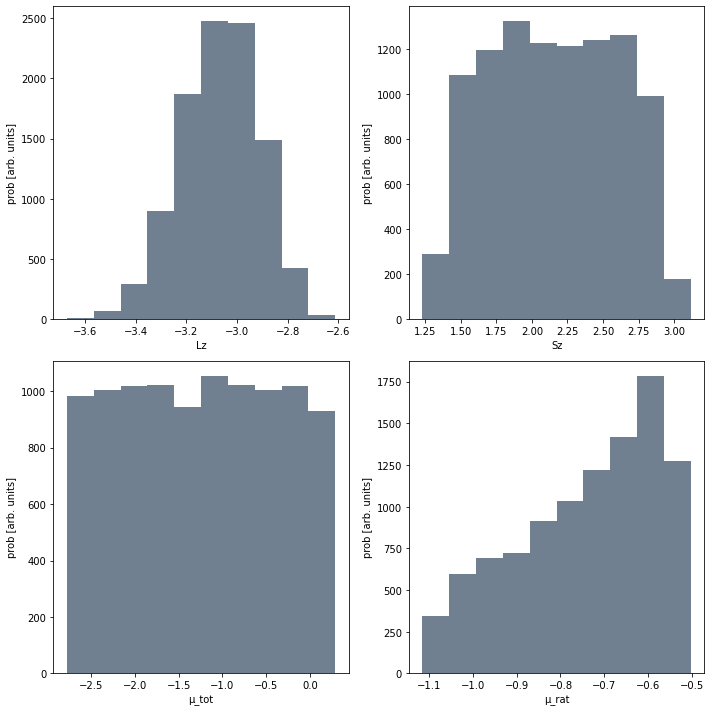

In [250]:
%matplotlib inline
print('Lz is ca', np.around(np.mean(lz_list),5),'+-', 
      np.around(np.std(lz_list), 5),'(µB)')
print('Sz is ca', np.around(np.mean(sz_list),5),'+-',
      np.around(np.std(sz_list), 5),'(µB)')
print('µtot is ca', np.around(np.mean(mu_tot_list),5),'+-',
      np.around(np.std(mu_tot_list), 5),'(µB)')
print('µratio is ca', np.around(np.mean(mu_rat_list)*100,5),'+-',
      np.around(np.std(mu_rat_list)*100, 5),'(%)')


fig, axs = plt.subplots(2,2,figsize=(10,10))

axs[0,0].hist(lz_list,bins=10,color='slategrey')
axs[0,0].set_xlabel('Lz')


axs[0,1].hist(sz_list,bins=10,color='slategrey')
axs[0,1].set_xlabel('Sz')



axs[1,0].hist(mu_tot_list,bins=10,color='slategrey')
axs[1,0].set_xlabel('µ_tot')

axs[1,1].hist(mu_rat_list,bins=10,color='slategrey')
axs[1,1].set_xlabel('µ_rat')

for i in range(2):
    for j in range(2):
        axs[i,j].set_ylabel('prob [arb. units]')
plt.tight_layout()
plt.show()

In [251]:
df = pd.DataFrame(whole_set,columns=['step1','step2','slope','branching_ratio','nh','tz','last_number_xas','last_number_xmcd','edge_divider'])
df2 = pd.DataFrame({'lz':lz_list, 'sz':sz_list, 
                    'mu_tot':mu_tot_list, 'mu_rat':mu_rat_list})
df3 = pd.concat([df2,df], axis=1)

<Axes: >

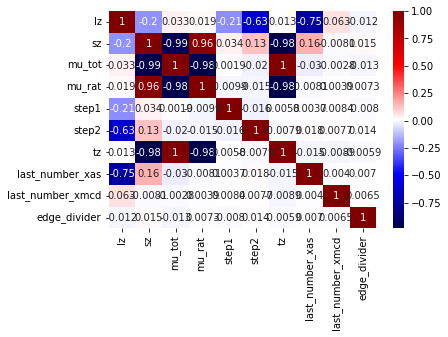

In [252]:
corr = df3.corr()
corr = corr.dropna(axis=0,how='all')
corr = corr.dropna(axis=1,how='all')
sb.heatmap(corr, cmap="seismic", annot=True)

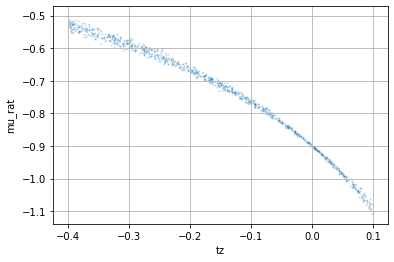

In [253]:
what_x = 'tz'
what_y = 'mu_rat'

plt.scatter(df3[what_x][:1000],df3[what_y][:1000],alpha=0.2,s=1)

plt.xlabel(what_x)
plt.ylabel(what_y)
plt.grid()

(array([ 983., 1000.,  995., 1052., 1047.,  974.,  916., 1007.,  991.,
        1035.]),
 array([-3.99953577e-01, -3.49959430e-01, -2.99965282e-01, -2.49971135e-01,
        -1.99976987e-01, -1.49982839e-01, -9.99886916e-02, -4.99945439e-02,
        -3.96285481e-07,  4.99937514e-02,  9.99878990e-02]),
 <BarContainer object of 10 artists>)

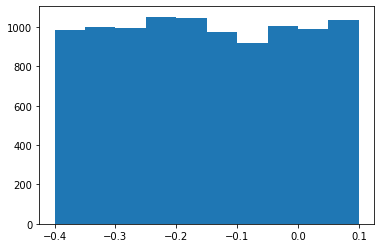

In [235]:
plt.hist(df3['tz'])

# PCA analysis:

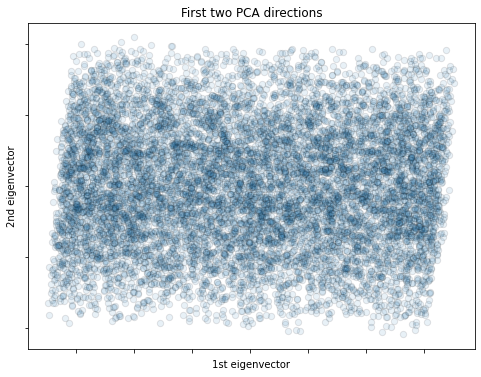

In [237]:
X_reduced = PCA(n_components=2).fit_transform(df)
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    edgecolor="k",
    s=40,
    alpha=0.1
)

ax.set_title("First two PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])


plt.show()